In [1]:
# Imports
import pandas as pd
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# Sklearn libraries.
from sklearn import datasets, linear_model, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
import string

from collections import Counter
#deep learning library

import json, os, re, shutil, sys, time
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz

from numpy import random
from numpy.random import multinomial

random.seed(10)


### 1. Load Data

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
# Unzip gz file.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

# Load JSON into dataframe.
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [4]:
start = time.time()
df = getDF('/home/legu/data/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
end = time.time()
print("Time Used %fs" %(end - start))

Time Used 38.415344s


### 2. Data Exploration

In [5]:
print df.columns

print df['reviewText'][0]

df.head(5)


Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary'],
      dtype='object')
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0000,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0000,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0000,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0000,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0000,"03 15, 2014",Grammy's Angels Love it


#### Exploring helpfulness scores.

In [6]:
helpfulness = []
total_votes = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
        total_votes.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        total_votes.append(i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
total_votes = np.array(total_votes)

In [7]:
for i, row in df.iterrows():
    helpful = row['helpful']
    if helpful[0] > helpful[1]:
        print row

reviewerID                                           A353U0L2HAMSHV
asin                                                     B000JD2614
reviewerName                   Cricket "Living life and loving it!"
helpful                                                      [4, 2]
unixReviewTime                                           1234828800
reviewText        I have been waiting for these to go on sale fo...
overall                                                      5.0000
reviewTime                                              02 17, 2009
summary                                              A gift for me!
Name: 30730, dtype: object


In [28]:
#  remove the invalid entries
helpfulness_clean = np.delete(helpfulness, 30730)
doc = np.array(df['reviewText'])
doc_clean = np.delete(doc, 30730)

# remove the nan values
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]
nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]
y = np.reshape(nonnan_helpfulness_clean,(-1,1))

#binarize

y_norm = np.argmax(np.concatenate((1-y,y), axis = 1),1)

In [29]:
print (nonnan_helpfulness_clean[0])
print (nonnan_doc_clean[0])
print (y[0])
print (y_norm[0])

0.875
For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!
[ 0.875]
1


In [31]:
print(y_norm[1:15])
print(y[1:15])

[1 0 1 0 0 1 1 1 1 0 1 1 1 1]
[[ 1.        ]
 [ 0.5       ]
 [ 1.        ]
 [ 0.        ]
 [ 0.5       ]
 [ 0.9804878 ]
 [ 0.83333333]
 [ 0.84615385]
 [ 0.77419355]
 [ 0.        ]
 [ 0.93939394]
 [ 0.91176471]
 [ 0.77777778]
 [ 0.83333333]]


### 3. Balance the dataset and generate train/dev/test dataset 

#### Copied from Le's split to train/test/dev
Revisit deleting above cells.

In [32]:
n_total_samples = len(nonnan_doc_clean)# or whatever it is

indices = np.arange(n_total_samples)
inds_split = multinomial(n=1,
                         pvals=[0.8, 0.1, 0.1],
                         size=n_total_samples).argmax(axis=1)

train_inds = indices[inds_split==0]
test_inds  = indices[inds_split==1]
dev_inds   = indices[inds_split==2]

x_train = nonnan_doc_clean[train_inds]
y_train = y[train_inds]
y_train_norm = y_norm[train_inds]
x_test = nonnan_doc_clean[test_inds]
y_test = y[test_inds]
y_test_norm = y_norm[test_inds]
x_dev = nonnan_doc_clean[dev_inds]
y_dev = y[dev_inds]
y_dev_norm = y_norm[dev_inds]

In [36]:
##for dubug purpose
print (len(x_train))
print (len(x_dev))
print (len(x_test))
print (float(sum(y_train_norm))/len(x_train))
print (float(sum(y_dev_norm))/len(x_dev))
print (float(sum(y_test_norm))/len(x_test))
print (sum(y_dev_norm))
print(sum(np.rint(y_dev)))

69646
8657
8717
0.769850386239
0.773247083285
0.763680165194
6694
[ 6694.]


In [37]:
print(x_train[0])
print(x_test[0])

For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!
I've never had french, learned french, or know anything about French. Now, however, I feel like I could do OK with a quick trip and to get around conversationally. Rosetta Stone is no substitute for deep immersion learning, but it's pretty useful as a tool to learn the basics.Pros:- Builds a LOT of vocabulary quickly- Helps understand what words mean by associating them with a concept, rather than translating- Internet community is pretty cool.Cons:- Doesn't focu

In [170]:
##upsample
import random
ind_0 = np.where(y_train_norm == 0)[0]
ind_1 = np.where(y_train_norm == 1)[0]
ind_upsamp = np.random.choice(ind_0,size = len(ind_1),replace =1)
x_train_res= np.concatenate( [x_train[ind_upsamp] ,x_train[ind_1]],axis=0)
y_train_res= np.concatenate( [y_train[ind_upsamp] ,y_train[ind_1]],axis=0)
y_train_norm_res= np.concatenate( [y_train_norm[ind_upsamp] ,y_train_norm[ind_1]],axis=0)

In [174]:
##downsample
import random
ind_0 = np.where(y_train_norm == 0)[0]
ind_1 = np.where(y_train_norm == 1)[0]
ind_downsamp = np.random.choice(ind_1,size = len(ind_0),replace =0)
x_train_res= np.concatenate( [x_train[ind_downsamp] ,x_train[ind_0]],axis=0)
y_train_res= np.concatenate( [y_train[ind_downsamp] ,y_train[ind_0]],axis=0)
y_train_norm_res= np.concatenate( [y_train_norm[ind_downsamp] ,y_train_norm[ind_0]],axis=0)

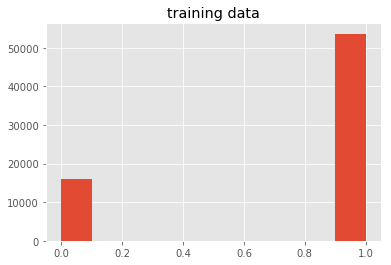

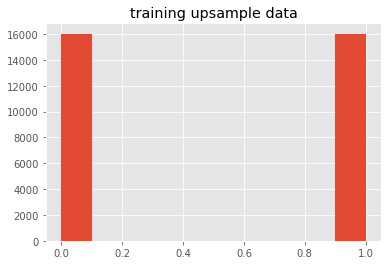

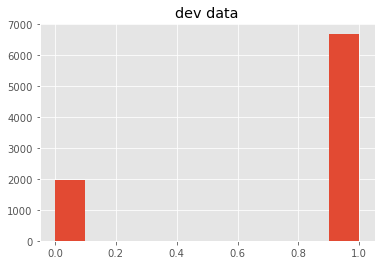

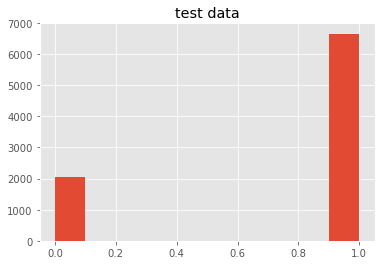

Training data set is of size 69646: there are 16029 0 lables, and 53617 1 labels. After upsampling, there are total 32058 samples


In [175]:
plt.hist(y_train_norm)
plt.title('training data')
plt.show()

plt.hist(y_train_norm_res)
plt.title('training upsample data')
plt.show()


plt.hist(y_dev_norm)
plt.title('dev data')
plt.show()


plt.hist(y_test_norm)
plt.title('test data')
plt.show()



print ('Training data set is of size %i: there are %i 0 lables, and %i 1 labels. After upsampling, there are total %i samples'
       %(len(x_train),len(np.where(y_train_norm == 0)[0]),len(np.where(y_train_norm == 1)[0]),len(x_train_res)))


#### 2.Convert the review from list of words to list of word dictionary index

In [176]:
def get_tokens(docs):
    tokens =[]
    for i in docs:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        tokens.extend(token)
    return tokens

tokens = get_tokens(x_train_res)

In [177]:
# Vocab size.
V = 10000
def build_dataset(words):
    
    # Leave the last index for all other words.
    count = collections.Counter(words).most_common(V-1)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [178]:
dic, rev_dict = build_dataset(tokens)

In [179]:
def transform_words_to_index(words, dictionary):
    #build sample data
    ids = []
    for i in words:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        j = []
        for w in token:
            if w in dictionary:
                j.append(dictionary[w])
            # Set token_id to vocab size - 1 if word not in top words
            # since this is zero indexed.
            else:
                j.append(V-1)
        ids.append(j)
    return ids

In [180]:
x_train_res_ids = transform_words_to_index(x_train_res, dic)
x_dev_ids = transform_words_to_index(x_dev, dic)
x_test_ids = transform_words_to_index(x_test, dic)

In [181]:
print (x_train_res[0])
print (x_train_res_ids[0])
print (y_train_res[0])
print (y_train_norm_res[0])


print (x_test[0])
print (x_test_ids[0])
print (y_test[0])
print (y_test_norm[0])

print (x_dev[0])
print (x_dev_ids[0])
print (y_dev[0])
print (y_dev_norm[0])

I bought this for a specific dress and it just didn't work.  But I would have kept it if it did...very nice and soft.
[1, 67, 10, 7, 3, 2311, 112, 2, 5, 32, 138, 108, 13, 1, 34, 18, 554, 5, 35, 5, 9999, 63, 2, 149]
[ 0.66666667]
1
I've never had french, learned french, or know anything about French. Now, however, I feel like I could do OK with a quick trip and to get around conversationally. Rosetta Stone is no substitute for deep immersion learning, but it's pretty useful as a tool to learn the basics.Pros:- Builds a LOT of vocabulary quickly- Helps understand what words mean by associating them with a concept, rather than translating- Internet community is pretty cool.Cons:- Doesn't focus on grammar at all- Level 1 doesn't contain a whole lot- It's obviously pretty expensive. I guess if you're *really* interested, it's worth it.For it's purpose, it is almost perfect software. You will feel confident with the basics after this.
[122, 201, 52, 4242, 1766, 4242, 36, 163, 306, 73, 4242, 

#### 3.Pad the sentence with differnt length

In [182]:
#combine the list of words index and label into a dataframe
train_df = pd.DataFrame(np.column_stack([x_train_res_ids,y_train_norm_res]), 
                               columns=['list_words', 'label'])
#combine the list of words index and label into a dataframe
dev_df = pd.DataFrame(np.column_stack([x_dev_ids,y_dev_norm]), 
                               columns=['list_words', 'label'])
#combine the list of words index and label into a dataframe
test_df = pd.DataFrame(np.column_stack([x_test_ids,y_test_norm]), 
                               columns=['list_words', 'label'])

In [183]:
print (len(train_df))
train_df.head()

32058


,list_words,label
0,"[1, 67, 10, 7, 3, 2311, 112, 2, 5, 32, 138, 10...",1
1,"[1, 375, 190, 5255, 2207, 2, 2958, 2, 198, 4, ...",1
2,"[134, 56, 2, 95, 7, 3, 3143, 17, 0, 127, 1, 27...",1
3,"[83, 54, 1, 185, 0, 2313, 1526, 383, 12, 317, ...",1
4,"[1, 67, 19, 50, 60, 12, 14, 713, 7, 302, 199, ...",1


In [184]:
print (len(dev_df))
dev_df.head()

8657


,list_words,label
0,"[0, 4325, 816, 1534, 677, 24, 8516, 237, 83, 1...",1
1,"[1, 91, 10, 152, 7, 11, 1145, 199, 2156, 946, ...",1
2,"[1, 91, 4325, 816, 3455, 1438, 462, 3, 186, 35...",1
3,"[10, 77, 3, 173, 8, 329, 2, 286, 6, 25, 749, 3...",1
4,"[358, 121, 10, 152, 1, 21, 334, 328, 4, 9999, ...",1


In [185]:
print (len(test_df))
test_df.head()

8717


,list_words,label
0,"[122, 201, 52, 4242, 1766, 4242, 36, 163, 306,...",1
1,"[4325, 816, 6, 6719, 7, 5724, 4296, 0, 114, 64...",1
2,"[18, 12, 731, 203, 9999, 130, 661, 7, 3, 629, ...",0
3,"[5, 665, 24, 355, 4, 171, 70, 2419, 87, 9, 3, ...",1
4,"[49, 10, 152, 33, 76, 2, 105, 130, 70, 540, 2,...",1


In [186]:
class SimpleDataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        return res['list_words'], res['label'] 
    
data = SimpleDataIterator(train_df)
a,b = data.next_batch(3)
print(a)
print(b)

0    [16, 84, 142, 5, 18, 3, 1756, 13, 5, 2373, 9, ...
1    [1, 75, 10, 39, 20, 222, 1999, 13, 324, 4, 155...
2    [49, 0, 112, 5, 105, 231, 2, 340, 609, 37, 256...
Name: list_words, dtype: object
0    1
1    0
2    1
Name: label, dtype: object


In [187]:
##this helps to make sure each sentence have the same length (max_len)
class PaddedDataIterator(SimpleDataIterator):
    def next_batch(self, n, max_len):
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
#             self.max_len = max_len
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        maxlen = max_len
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(res['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = res['list_words'].values[i][:max_len]
            else:
                x_i[:l] = res['list_words'].values[i][:l]

        return x, res['label'] 
    def pad_sentences(self, n, max_len):
        maxlen = max_len
        x = np.zeros([len(self.df), maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(self.df['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = self.df['list_words'].values[i][:max_len]
            else:
                x_i[:l] = self.df['list_words'].values[i][:l]

        return x, self.df['label'] 

In [188]:
# This cell is not needed. Just for debugging.
#sample call to get the data
max_length = 100 
a, b = PaddedDataIterator(train_df).next_batch(1,max_length)
a1, b1 = PaddedDataIterator(test_df).pad_sentences(1,max_length)
print (a)
print (b)
print (len(a1))
print (len(b1))

[[ 316   92    8    0  192    2   12  262    4  127   20    3  235   29
    58    3   29 1611 2422    2 4580   22    1   75    3   76    2    5
    21   40  153    4   28 1532   58  184    0 9999   34   49    5   10
   153   13    7    3 1532   59    5  845   21   16   71   51   15    0
   175   21   37    2  741    1   32  287    5   34   18   31   46    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
0    0
Name: label, dtype: object
8717
8717


#### 4.build RNN model 

In [189]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt

def visualizeTraining(iters, costs, accs):

    x = iters
    y = costs
    z = accs

    plt.scatter(x, y )
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.show()

    plt.scatter(x, z)
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.show()

    print ("Dev Accuracy:",dev_acc)
    print("Dev cost:",dev_cost)    
    print("Dev F1=%.5f, Precision=%.5f, Recall=%.5f" %(f1,precision,recall))

In [200]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf
import sklearn as sk
from tensorflow.contrib import rnn

# Import MNIST data


'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''
######################## 
### MODEL PARAMETERS ###
######################## 


# Parameters
learning_rate = 0.1
training_iters = 200000
batch_size = 1000
display_step = 2
sentence_size = 150

# Network Parameters
n_input = 3   
n_steps = sentence_size/n_input # timesteps
n_hidden = 20 # hidden layer num of features
n_classes = 2  
vocab_size = 10000


#################################
### PLACEHOLDER AND VARIABLE ###
#################################

# tf Graph input
x = tf.placeholder("int32", [None, n_steps, n_input])
y = tf.placeholder("int32", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}


######################## 
### DEFINE RNN MODEL ###
######################## 
def MakeFancyRNNCell(H, keep_prob, num_layers=1):
    """Make a fancy RNN cell.
    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.
    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers
    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
        cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
        cell = tf.contrib.rnn.DropoutWrapper(
          cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
        cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


def RNN(x, weights, biases):
    
    with tf.name_scope("Embedding_Layer"):
        C_ = tf.Variable(tf.random_uniform([vocab_size, n_hidden], -1.0, 1.0), name="C")
        # embedding_lookup gives shape (batch_size, N, M)
        test = tf.nn.embedding_lookup(C_, x)
        print(test.shape)
        x_ = tf.reshape(tf.nn.embedding_lookup(C_, x), 
                        [-1, n_steps, n_input*n_hidden], name="x")
        print(x_.shape)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    print(x.shape)
    x = tf.unstack(x_, n_steps, 1)
    print(len(x))
    print(x[0].shape)
    
    with tf.variable_scope("first_lstm"+str(randint(0, 1000))):
        # Define a lstm cell with tensorflow
#         lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
        lstm_cell = MakeFancyRNNCell(n_hidden, keep_prob = 1.0, num_layers=1)
        # Get lstm cell output
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits_ = RNN(x, weights, biases)



#############################
### LOSS AND OPTIMIZATION ###
#############################

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    
##################
### EVALUATION ###
################## 
pred_ = 1-tf.argmax(logits_,1)
actual_labels_ = 1-tf.argmax(y,1)
correct_pred_ = tf.equal(pred_, actual_labels_)
# correct_pred_ = tf.equal(tf.argmax(logits_,1), tf.argmax(y,1))
accuracy_ = tf.reduce_mean(tf.cast(correct_pred_, tf.float32))



#################
### RUN GRAPH ###
#################

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    iters=[]
    costs=[]
    accs=[]
    f1s=[]
    precisions=[]
    recalls=[]

    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        
        ##########################
        ### GENERATE BATCH X,Y ###
        ##########################
        batch_x, batch_y_1 = PaddedDataIterator(train_df).next_batch(batch_size,sentence_size)
        batch_y = np.concatenate((batch_y_1.reshape([-1,1]), 1-batch_y_1.reshape([-1,1])), axis=1)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        
        
        ################
        ### TRAINING ###
        ################
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        #################
        ### REPORTING ###
        #################
        
        if step % display_step == 0:
            # Calculate batch accuracy, loss
            acc,loss = sess.run([accuracy_,cost], feed_dict={x: batch_x, y: batch_y})
#             precision = sk.metrics.precision_score(acc_labels, preds)
#             precisions.append(precision)
#             recall = sk.metrics.recall_score(acc_labels, preds)
#             recalls.append(recall)
#             f1 = sk.metrics.f1_score(acc_labels, preds)
#             f1s.append(f1)
            iters.append(step*batch_size)
            costs.append(loss)
            accs.append(acc)
#             print( sess.run(pred, feed_dict={x: batch_x, y: batch_y}))
#             print("Iter: %s, Minibatch Loss=%.6f, Training Accuracy=%.5f, F1=%.5f, Precision=%.5f, Recall=%.5f" %(
#                 str(step*batch_size),loss,acc,f1,precision,recall))
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    
    ##########################
    ### EVALUATE WITH DEV DATA ###
    ##########################    
    
    batch_x_dev_1, batch_y_1_dev = PaddedDataIterator(dev_df).next_batch(len(dev_df),sentence_size)
    batch_x_dev = batch_x_dev_1.reshape([-1,n_steps, n_input])
    batch_y_dev = np.concatenate((batch_y_1_dev.reshape([-1,1]), 1-batch_y_1_dev.reshape([-1,1])), axis=1)
#     dev_acc, dev_cost = sess.run([accuracy_, cost],feed_dict={x: batch_x_dev, y: batch_y_dev})
    dev_pred,dev_acc_labels,dev_acc, dev_cost,logits = sess.run([pred_,actual_labels_,accuracy_, cost,logits_],
                                                         feed_dict={x: batch_x_dev, y: batch_y_dev})
    precision = sk.metrics.precision_score(dev_acc_labels, dev_pred)
    recall = sk.metrics.recall_score(dev_acc_labels, dev_pred)
    f1 = sk.metrics.f1_score(dev_acc_labels, dev_pred)
#     print (sess.run([logits_], feed_dict={x: batch_x_dev}))
    print ("Dev Accuracy:",dev_acc)
    print("Dev cost:",dev_cost)  
    print("F1=%.5f, Precision=%.5f, Recall=%.5f" %(f1,precision,recall))
    


(?, 50, 3, 20)
(?, 50, 60)
(?, 50, 3)
50
(?, 60)


/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:157: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Iter 2000, Minibatch Loss= 4.050401, Training Accuracy= 0.52500
Iter 4000, Minibatch Loss= 0.727729, Training Accuracy= 0.51800
Iter 6000, Minibatch Loss= 0.975808, Training Accuracy= 0.52300
Iter 8000, Minibatch Loss= 0.822833, Training Accuracy= 0.52300
Iter 10000, Minibatch Loss= 0.712228, Training Accuracy= 0.53600
Iter 12000, Minibatch Loss= 0.692922, Training Accuracy= 0.51100
Iter 14000, Minibatch Loss= 0.699860, Training Accuracy= 0.47400
Iter 16000, Minibatch Loss= 0.698358, Training Accuracy= 0.53400
Iter 18000, Minibatch Loss= 0.685204, Training Accuracy= 0.54200
Iter 20000, Minibatch Loss= 0.687945, Training Accuracy= 0.53100
Iter 22000, Minibatch Loss= 0.688352, Training Accuracy= 0.50400
Iter 24000, Minibatch Loss= 0.686336, Training Accuracy= 0.53100
Iter 26000, Minibatch Loss= 0.684168, Training Accuracy= 0.54400
Iter 28000, Minibatch Loss= 0.678124, Training Accuracy= 0.53100
Iter 30000, Minibatch Loss= 0.682690, Training Accuracy= 0.53400
Iter 32000, Minibatch Loss= 0

/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:195: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Dev Accuracy: 0.275384
Dev cost: 0.73962
F1=0.14151, Precision=0.84339, Recall=0.07723


In [201]:
print(dev_pred)
print(dev_acc_labels)
print(logits)

[0 0 0 ..., 0 0 0]
[1 1 1 ..., 1 1 1]
[[-0.18959135 -0.05353487]
 [-0.18959135 -0.05353487]
 [-0.18959135 -0.05353487]
 ..., 
 [-0.18959135 -0.05353487]
 [-0.18959135 -0.05353487]
 [-0.18959138 -0.05353487]]


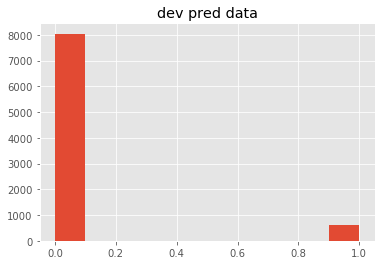

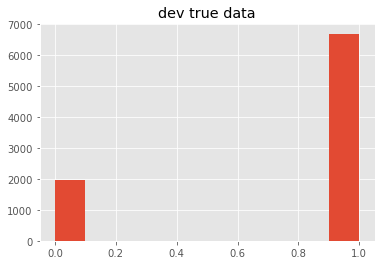

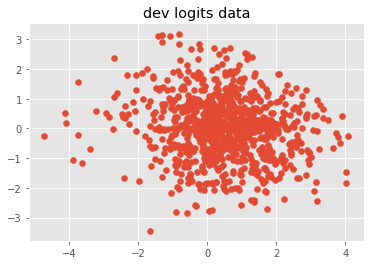

In [202]:
plt.hist(dev_pred)
plt.title('dev pred data')
plt.show()

plt.hist(dev_acc_labels)
plt.title('dev true data')
plt.show()


plt.scatter(logits[:,0],logits[:,1])
plt.title('dev logits data')
plt.show()


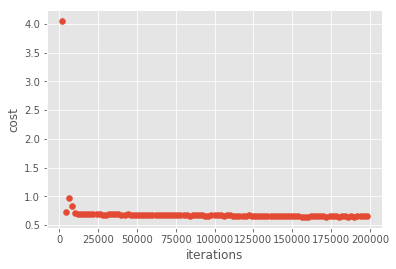

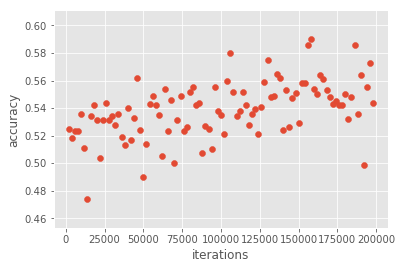

Dev Accuracy: 0.275384
Dev cost: 0.73962
Dev F1=0.14151, Precision=0.84339, Recall=0.07723


In [203]:
# Original without FancyRNN
visualizeTraining(iters, costs, accs)

In [152]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    batch_x_dev_1, batch_y_1_dev = PaddedDataIterator(dev_df).pad_sentences(len(dev_df),sentence_size)
    batch_x_dev = batch_x_dev_1.reshape([-1,n_steps, n_input])
    batch_y_dev = np.concatenate((batch_y_1_dev.reshape([-1,1]), 1-batch_y_1_dev.reshape([-1,1])), axis=1)
    actual_labels = sess.run([actual_labels_], feed_dict={y: batch_y_dev})
    print (sess.run([logits_], feed_dict={x: batch_x_dev}))

/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


[array([[-0.68189043,  0.55951405],
       [-0.64171457,  0.56740332],
       [-0.64182973,  0.56753111],
       ..., 
       [-0.64165807,  0.56737763],
       [-0.34472778,  0.70948088],
       [-0.64174449,  0.56744111]], dtype=float32)]


In [129]:
print(len(dev_df))
print(np.sum(actual_labels))
print(sum(batch_y_dev))
print(len(batch_y_1_dev))
print(sum(1-np.argmax(batch_y_dev,1)))
print(sum(np.rint(np.array(batch_y_1_dev).astype(float))))
print(sum(np.rint(np.array(batch_y_dev[:,0]).astype(float))))
print(actual_labels[:20])
print(batch_y_dev[0:20,0])

8657
6694
[6694 1963]
8657
6694
6694.0
6694.0
[array([1, 0, 1, ..., 1, 0, 0])]
[1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0]


In [145]:
dev_pred [0] ==batch_y_dev[:,0]

array([ True, False,  True, ...,  True, False, False], dtype=bool)

In [153]:
dev_pred

array([1, 0, 0, ..., 0, 0, 0])

In [151]:
print(len(dev_pred [0] ==batch_y_dev[:,0]))
print(sum(dev_pred ==batch_y_dev[:,0]))
print(sum(dev_pred [0]))
print (sum(batch_y_dev[:,0]))

8657
2492


TypeError: 'numpy.int64' object is not iterable

In [142]:
len(actual_labels[0])

8657

In [143]:
dev_pred

array([1, 0, 0, ..., 0, 0, 0])

#### logistic Regression

In [106]:
##tf-idf transformation
##based on this page: http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
token_dict_train = {}
token_dict_dev = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

for i, text in enumerate(x_train_res):
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    token_dict_train[i] = no_punctuation

for i, text in enumerate(x_dev):
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    token_dict_dev[i] = no_punctuation
    
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs_train = tfidf.fit_transform(token_dict_train.values())
tfs_dev = tfidf.transform(token_dict_dev.values())

In [116]:
print(tfs_train.shape)
print(tfs_dev.shape)
print(len(y_train_norm_res))
print(len(y_dev))

(107234, 92653)
(8657, 92653)
107234
8657


In [120]:
regr2 = linear_model.LogisticRegression()

# Train the model using the training sets
regr2.fit(tfs_train, y_train_norm_res)
print(regr2)
# make predictions
predicted2 = regr2.predict(tfs_dev)
print (predicted2[0:10])
# The coefficients
print('Coefficients: \n', regr2.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % np.mean((predicted2 - y_dev) ** 2))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % regr2.score(X_test, y_test_norm))
print(metrics.classification_report(y_dev_norm, predicted2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[0 1 1 1 0 1 1 1 1 0]
Coefficients: 
 [[-0.37156984  0.01142682 -0.9484188  ...,  0.08983767 -0.26386824
   0.15974426]]
             precision    recall  f1-score   support

          0       0.31      0.47      0.37      1963
          1       0.82      0.69      0.75      6694

avg / total       0.70      0.64      0.66      8657



In [126]:
print (sum(actual_labels==batch_y_dev))

/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


TypeError: 'bool' object is not iterable

In [144]:
print(dev_pred[:100])
print(sum(dev_pred))
print(dev_acc_labels[:100])
print(sum(dev_acc_labels))
print(len(dev_acc_labels))
print(dev_acc)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
8548
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0]
7453
8721
0.838895


In [70]:
def computeDevScores():
    precision = sk.metrics.precision_score(dev_acc_labels, dev_pred)
    recall = sk.metrics.recall_score(dev_acc_labels, dev_pred)
    f1 = sk.metrics.f1_score(dev_acc_labels, dev_pred)
    print("F1=%.5f, Precision=%.5f, Recall=%.5f" %(f1,precision,recall))
    precision2 = sk.metrics.precision_score(y_dev_norm, dev_pred)
    recall2 = sk.metrics.recall_score(y_dev_norm, dev_pred)
    f12 = sk.metrics.f1_score(y_dev_norm, dev_pred)
    print("F1=%.5f, Precision=%.5f, Recall=%.5f" %(f12,precision2,recall2))

In [145]:
# With 1 layer
computeDevScores()

F1=0.91219, Precision=0.85377, Recall=0.97920
F1=0.86190, Precision=0.76989, Recall=0.97888


In [142]:
# With 3 layers
computeDevScores()

F1=0.92160, Precision=0.85460, Recall=1.00000
F1=0.87063, Precision=0.77090, Recall=1.00000


In [119]:
def computeTestAccuracy():
    batch_x_test_1, batch_y_1_test = PaddedDataIterator(test_df).next_batch(len(test_df),sentence_size)
    batch_x_test = batch_x_test_1.reshape([-1,n_steps, n_input])
    batch_y_test = np.concatenate((batch_y_1_test.reshape([-1,1]), 1-batch_y_1_test.reshape([-1,1])), axis=1)
    test_acc, test_cost = sess.run([accuracy, cost], feed_dict={x: batch_x_test, y: batch_y_test})
    print ("Test Accuracy:",test_acc)

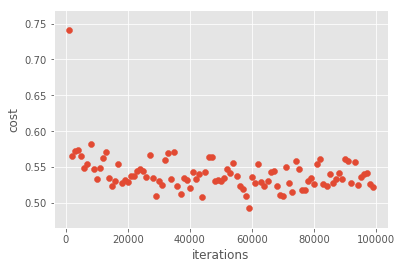

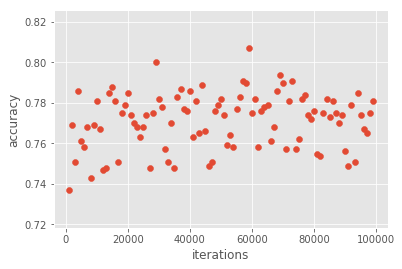

Testing Accuracy: 0.777
Testing cost: 0.530469


In [31]:
# Changed to Fancy RNN
# 1.0 keep_prob
# 1 layer
visualizeTraining(iters, costs, accs)

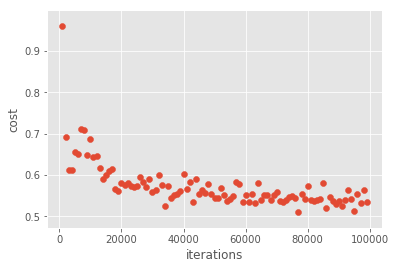

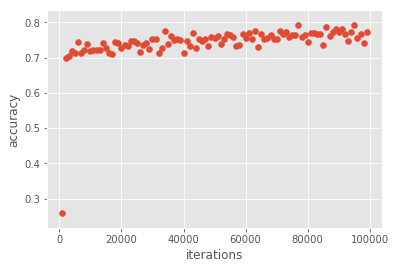

Testing Accuracy: 0.77
Testing cost: 0.536199


In [33]:
# Changed to Fancy RNN (2nd run same settings)
# 1.0 keep_prob
# 1 layer
visualizeTraining(iters, costs, accs)

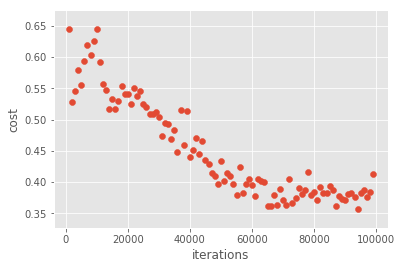

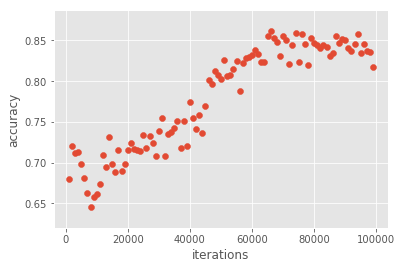

Testing Accuracy: 0.85
Testing cost: 0.383113


In [58]:
# Original without FancyRNN but using prob instead of one-hot
visualizeTraining(iters, costs, accs)

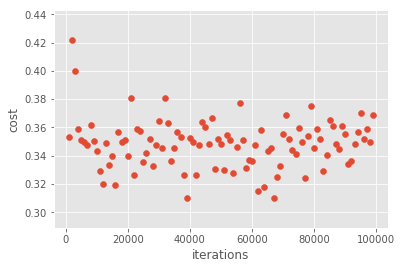

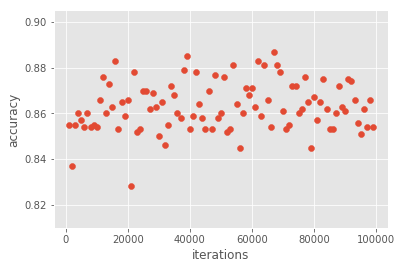

Testing Accuracy: 0.856
Testing cost: 0.364555


In [60]:
# Default FancyRNN but using prob instead of one-hot
visualizeTraining(iters, costs, accs)

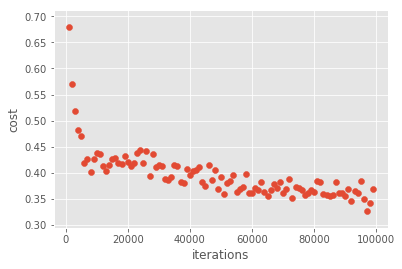

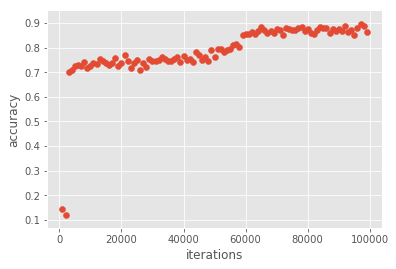

Testing Accuracy: 0.867
Testing cost: 0.362405


In [62]:
# Default FancyRNN but using prob instead of one-hot
# 2 LSTM layers
visualizeTraining(iters, costs, accs)

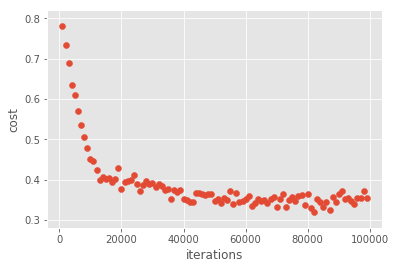

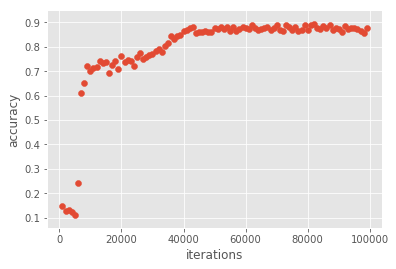

Testing Accuracy: 0.878
Testing cost: 0.348885


In [64]:
# Default FancyRNN but using prob instead of one-hot
# 3 LSTM layers
visualizeTraining(iters, costs, accs)

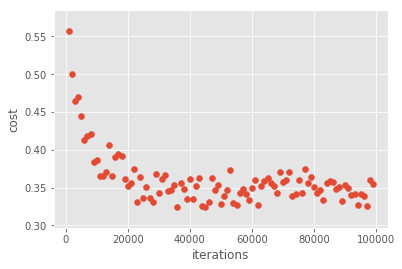

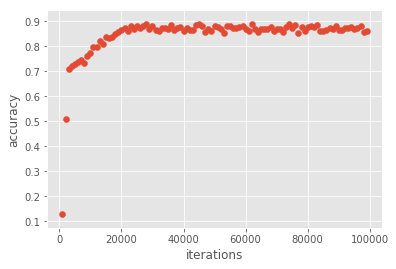

Dev Accuracy: 0.870905
Dev cost: 0.341749


In [123]:
# Default FancyRNN but using prob instead of one-hot
# 3 LSTM layers
visualizeTraining(iters, costs, accs)

In [120]:
# Compute Test Accuracy
computeTestAccuracy()

/home/annie_y_lee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


RuntimeError: Attempted to use a closed Session.

### Scratch below

In [177]:
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(batch_size,100)

In [159]:
batch_x

array([[   5,  176,   34,   33,   55,  473,    5,  371,   68,  111,    4,
        2523,  133,    5,   34,  371,    3,  140,  539,    2,   55,    1,
        2409,   22,    1,   64,  210,   20,  237,    5,  175,  335,   21,
           5,  193,  271,    5, 1097,  326,   53,    1,  216,   57,    9,
        1349,    1,   17,   10,  150,   15,  266,    4,  213,   31, 2480,
           9,  849,    1,   17,   15, 2183, 1508,  426,   11,   15,  352,
          13, 2397,  432,    4,    3,  179, 1624,   40,    0, 2087,  663,
           4,  891,  819,    2,  215,  192,   11,  512,    0,  266,  822,
           7,    3,   62,  207,   23,    1,   43,    2,  612,    5,  125,
          23],
       [   1,  182,   10,   91,    3,   62,  100,    3,  160,  329,  136,
          12,    1,   78,  451,   13,    5,    1,  263,    2,  968,    5,
           1,  124,    5,   16, 1273,    4, 1381,   36,   43,  131, 2129,
        1394,    0, 1723,    4,   17,  101,  692,    0, 1882,   11,    0,
        1361, 2415, 206

In [163]:
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(batch_size,100)
batch_x = batch_x.reshape((batch_size, n_steps, n_input))

x = tf.unstack(x, n_steps, 1)

In [161]:
tf.unstack(x, n_steps, 1)

[<tf.Tensor 'unstack_5:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:1' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:2' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:3' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:4' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:5' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:6' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:7' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:8' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:9' shape=(?, 10) dtype=float32>]

In [156]:
from tensorflow.contrib import rnn

In [ ]:
##define variables 
n_hidden = 10 
with tf.variable_scope("softmax"):
    W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
    b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")

with tf.variable_scope("recurrent"):
    rnn_cell = rnn.BasicLSTMCell(n_hidden)
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    initial_h_ = self.cell_.zero_state(self.batch_size_,dtype=tf.float32)
    outputs, self.final_h_ = tf.nn.dynamic_rnn(self.cell_, inputs=self.x_,initial_state=self.initial_h_, sequence_length=100)



In [196]:
def MakeFancyRNNCell(H, keep_prob, num_layers=1):
    """Make a fancy RNN cell.

    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.

    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers

    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
        cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
        cell = tf.contrib.rnn.DropoutWrapper(
        cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
        cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


In [36]:
##have to fix here!!!
def RNN(x):
    n_hidden = 10 
    with tf.variable_scope("softmax"):
        W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
        b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")
    # reshape to [1, n_input]
    n_input = len(x)
    x = tf.reshape(x, [-1, n_input])

    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    x = tf.split(x,n_input,1)
#     print x
    # 1-layer LSTM with n_hidden units.
#     with tf.variable_scope('cell_def'):
#         lstm_cell = MakeFancyRNNCell(H=n_hidden,keep_prob=1)
    lstm_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden, forget_bias=0.0)
#     print x
    # generate prediction

    
#     with tf.variable_scope('rnn_def',reuse=True):
    initial_h_ = lstm_cell.zero_state(1,dtype=tf.int32)
    outputs,final_h_ = tf.contrib.rnn.static_rnn(lstm_cell, x,dtype=tf.int32)
            
            

    # there are n_input outputs but
    # we only want the last output
    return tf.matmul(outputs[-1], W_out_) + b_out_

In [37]:
import tensorflow as tf
from tensorflow.contrib import rnn


learning_rate =0.1
pred = RNN(X_sample_ids[0])

# Loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_sample[0]))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

AttributeError: 'module' object has no attribute 'static_rnn'

In [ ]:
_, loss, onehot_pred = session.run([optimizer, cost, pred], 
                                        feed_dict={x: symbols_in_keys, y: symbols_out_onehot})

### Scratch below

In [17]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(60843,)
(26177,)
(60843, 1)
(26177, 1)


In [18]:
X_sample = nonnan_doc_clean[0:100]
y_sample = y[0:100]

In [19]:
print len(X_sample[0].split())
print X_sample[0]
print y[0]

35
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++
[ 0.875]


In [22]:
len(nltk.corpus.__getattr__('brown').words())

1161192

In [86]:
corpus = X_sample[0].split()
bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)

In [87]:
for i, (w,y) in enumerate(bi):
    print w
    print y_sample[0]

[['For' 'what' 'I' 'paid' 'for' 'two' 'tutus' 'is' 'unbeatable' 'anywhere!'
  'I' 'ordered' 'a' 'pink' 'and' 'turquios' 'and' 'they' 'are' 'vibrant'
  'and' 'beautiful!' 'The' 'tutu' 'is' 'very' 'full!' 'Princess' 'style!'
  'Not' 'cheaply' 'made!' 'Not' 'cheap' 'materia!' 'Obviously' 'someone'
  'made' 'these' 'with' 'love' 'and' 'care!' 'I' 'paid' 'less' 'than' '7'
  'bucks' 'for' 'a' 'tutu' 'I' 'and' 'I' 'feel' 'proud' 'of' 'my' 'self'
  'for' 'researching' 'to' 'the' 'point' 'of' 'finding' 'gold!Recommend'
  '2-6' 'years!My' 'daughter' 'is' 'two' '!' 'Wears' 'size' '4t' 'and'
  'this' 'skirt' '(' 'one' 'size' ')' 'fit' 'perfect' 'and' 'will'
  'probaly' 'be' 'able' 'to' 'accommodate' 'her' 'quickly' 'growing'
  'waist' 'for' 'some']]
[ 0.875]


In [99]:
import rnnlm
# import rnnlm_test
reload(rnnlm)
# reload(rnnlm_test)

<module 'rnnlm' from 'rnnlm.py'>

In [92]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        #### YOUR CODE HERE ####
        
        feed_dict = {lm.input_w_:w,
                 lm.target_y_:y,
                 lm.learning_rate_:learning_rate,
                 lm.initial_h_ : h}
            
        cost, _, h = session.run([loss, train_op,lm.final_h_],
                       feed_dict=feed_dict)
        
        
            
            
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print "[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost)
            tick_time = time.time()  # reset time ticker

    return total_cost / total_batches

In [93]:
V=1000
max_time = 20
batch_size = 50
learning_rate = 0.5
num_epochs = 5

# Model parameters
model_params = dict(V=100, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=1)

# TF_SAVEDIR = "tf_saved"
# checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
# trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [101]:
# Will print status every this many seconds
import rnnlm
# import rnnlm_test
reload(rnnlm)
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
# shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
# if not os.path.isdir(TF_SAVEDIR):
#     os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
#         bi = utils.batch_generator(train_ids, batch_size, max_time)
        corpus = X_sample[0].split()
        bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)
        for i, (w,y) in enumerate(bi):
            w1=w
            
        bi= (w1,y_sample[y])
        print "[epoch %d] Starting epoch %d" % (epoch, epoch)
        #### YOUR CODE HERE ####
        # Run a training epoch.
        cost = run_epoch(lm, session, bi, 
                     learning_rate=learning_rate, train=True, 
                     verbose=False, tick_s=3600)

        #### END(YOUR CODE) ####
        print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
        ##
        # score_dataset will run a forward pass over the entire dataset
        # and report perplexity scores. This can be slow (around 1/2 to 
        # 1/4 as long as a full epoch), so you may want to comment it out
        # to speed up training on a slow machine. Be sure to run it at the 
        # end to evaluate your score.
        print ("[epoch %d]" % epoch),
        #score_dataset(lm, session, train_ids, name="Train set")
        print ("[epoch %d]" % epoch),
        score_dataset(lm, session, test_ids, name="Test set")
        print ""
    
    # Save final model
    saver.save(session, trained_filename)

ValueError: Dimension must be 2 but is 3 for 'recurrent/transpose' (op: 'Transpose') with input shapes: [?,100], [3].

## Scratch Below

In [ ]:
print 1

In [62]:
import nltk
nltk.download('brown')

corpus = nltk.corpus.brown

[nltk_data] Downloading package brown to /Users/legu/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [72]:
!pip install vocabulary

    100% |████████████████████████████████| 593kB 408kB/s 
    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 102kB 1.2MB/s 
  Running setup.py bdist_wheel for vocabulary ... - \ done
  Stored in directory: /Users/legu/Library/Caches/pip/wheels/36/6c/c0/92bb20f79402d055c3bce3e89d9f2cce5d6937bc2aadc0fb45
Successfully built vocabulary
  Found existing installation: requests 2.11.1
    Uninstalling requests-2.11.1:
      Successfully uninstalled requests-2.11.1
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import utils
import vocabulary
# train_sents, test_sents = utils.get_train_test_sents(corpus, split=0.8, shuffle=True)
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(corpus))
print "Train set vocabulary: %d words" % vocab.size

AttributeError: 'module' object has no attribute 'Vocabulary'